## Custom Gymnasium Enviroment

Import whats needed

In [3]:
import numpy as np
import pandas as pd

In [4]:
# here we convert the jupiter file to a python script since it is easier to handle 
!jupyter nbconvert --to script --output rl_environment rl_environment.ipynb

[NbConvertApp] Converting notebook rl_environment.ipynb to script
[NbConvertApp] Writing 9145 bytes to rl_environment.py


Trading Enviroment Class

In [5]:
import gymnasium as gym         # Gymnasium is a library for building RL environments
                                # It provides a standard interface so RL algorithms (like PPO from Stable Baselines3) can interact with your environment.
from gymnasium import spaces    # spaces defines the action space and observation space for your environment

class TradingEnv(gym.Env):
    def __init__(self, data: pd.DataFrame, window_size=50):
        super().__init__()                              # initialize the base class
        self.data = data.reset_index(drop=True)         # reset index for easier slicing and store it in self.data
        self.window_size = window_size                  # number of previous candles to include in the observation
        self.current_step = window_size                 # start after the initial window

        # Observation: last N candles (OHLC + Volume)
        self.observation_space = spaces.Box(            # description of the observation space is given
            low=-np.inf, high=np.inf,                   # low and high values for each element in the observation are unbounded / infinite
            shape=(window_size, self.data.shape[1]),    # shape of the observation (window_size rows, number of features columns)
            dtype=np.float32                            # data type of the observation elements
        )
        # Actions: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)          # actually, there is not much we can do

    def reset(self, seed=None, options=None):           # reset the environment to initial state
        super().reset(seed=seed)                        # call the base class reset method
        self.current_step = self.window_size            # bring current step back to initial position
        return self._get_observation(), {}              # return the last known observation and an empty info dict
                                                        #   -> dict can be used to pass additional information like debugging info                                               

    def step(self, action):                             # do one step of the training
        reward = self._calculate_reward(action)         # calculate reward based on action taken - in the end the |profit/loss|
        self.current_step += 1                          # move to the next time step
        done = self.current_step >= len(self.data) - 1  # episode is done if we reach the end of the data
        return self._get_observation(), reward, done, False, {} 

    def _get_observation(self):
        obs = self.data.iloc[self.current_step - self.window_size:self.current_step].values # Return last N rows as observation ":" is NOT a division
        return obs.astype(np.float32)                   # return the last <windwow_size> observations as float32 numpy array

    def _calculate_reward(self, action):                # the REWARD is calculated based on the difference in closing prices
        if self.current_step + 1 >= len(self.data):     # check if we are at the end of the data
            print("End of data reached - we should never get here")
            return 0.0
        price_diff = self.data['Close'].iloc[self.current_step + 1] - self.data['Close'].iloc[self.current_step]
        if action == 1:   # BUY <-----------------------
            return price_diff
        elif action == 2: # SELL <----------------------
            return -price_diff
        else:             # HOLD <----------------------
            return 0.0

    
    def render(self, action=None, reward=None):  # render the current state of the environment
        msg = f"Step: {self.current_step}, Close Price: {self.data['Close'].iloc[self.current_step]}"
        if action is not None:  # if an action was taken, include it in the message
            msg += f", Action: {action}"
        if reward is not None:  # if a reward was given, include it in the message
            msg += f", Reward: {reward:.4f}"
        print(msg)



Get the data and normalize it with Z-score

In [6]:
# since StandardSkaler works column-wise, and OHLC value should have the SAME scaling, we have to do a bit of manual work here
class OHLCScaler:
    def __init__(self, train_df: pd.DataFrame):                     # with the init fct the hole dataset is given in for Open, High, 
                                                                    # Low, Close and Volume
        self.columns_ohlc = ['Open', 'High', 'Low', 'Close']        # all OHLC columns in one mean/std
        self.column_volume = 'Volume'                               # Volume column in a 2nd mean/std

        ohlc_values = train_df[self.columns_ohlc].values.flatten()  # get all given OHLC values from all columns 
        self.mean_ohlc = np.mean(ohlc_values)                       # calculate mean for OHLC values
        self.std_ohlc = np.std(ohlc_values)                         # calculate std for OHLC values

        volume_values = train_df[self.column_volume].values         # same for all Volume values
        self.mean_volume = np.mean(volume_values)
        self.std_volume = np.std(volume_values)

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:      # the transform method scales a hole given dataframe in the form Open, 
                                                                # High, Low, Close and Volume
        df_scaled = df.copy()
        for col in self.columns_ohlc:
            df_scaled[col]            = (df_scaled[col]                - self.mean_ohlc)   / self.std_ohlc
        df_scaled[self.column_volume] = (df_scaled[self.column_volume] - self.mean_volume) / self.std_volume
        return df_scaled
    
    def re_transform(self, normalized_gain: float, normalized_price: float) -> tuple:
        real_price = normalized_price * self.std_ohlc + self.mean_ohlc
        real_gain  = normalized_gain  * self.std_ohlc # for the gain the mean μ is not needed -> −μ−(−μ)=−μ+μ=0
        return real_gain, real_price


In [7]:
import joblib

# Load raw data
data = pd.read_csv('../data/Candlestick_01nov1999_28oct2025.csv', parse_dates=['date'], index_col='date')

# Split into train/test
split_idx  = int(len(data) * 0.8)
train_data = data.iloc[:split_idx]
test_data  = data.iloc[split_idx:]

# Fit OHLCScaler on training data
scaler = OHLCScaler(train_data)

# Transform train and test data
scaled_train_df = scaler.transform(train_data)
scaled_test_df  = scaler.transform(test_data)

# Save scaler for future use
joblib.dump(scaler, '../models/scaler.pkl')

['../models/scaler.pkl']

Understand the Data better

In [8]:
# let's have a look at the original data
print(data.head()) # print the first few rows of the original data
print("...")
print(data.tail())  # print the last few rows of the original data

             Open   High    Low  Close     Volume
date                                             
1999-11-01  107.5  107.6  106.5  106.5   559800.0
1999-11-02  107.0  107.7  105.7  105.7   975300.0
1999-11-03  106.8  106.8  105.8  106.2  1025500.0
1999-11-04  107.0  107.4  106.1  106.6   578600.0
1999-11-05  108.0  108.3  106.9  107.5  1139100.0
...
               Open     High      Low   Close     Volume
date                                                    
2025-10-22  469.210  469.240  464.480  465.78  7604676.0
2025-10-23  465.550  467.970  464.860  467.29  5144161.0
2025-10-24  470.020  473.240  469.280  472.21  7228912.0
2025-10-27  474.755  475.620  473.710  475.35  4720172.0
2025-10-28  478.800  479.405  476.815  477.15  9435484.0


In [9]:
# let's have a look at the scaled training data
print(scaled_train_df.head()) # print the first few rows of the scaled training data
print("...")
print(scaled_test_df.tail())  # print the last few rows of the scaled test data

                Open      High       Low     Close    Volume
date                                                        
1999-11-01 -0.657244 -0.655425 -0.675434 -0.675434 -0.986182
1999-11-02 -0.666339 -0.653606 -0.689987 -0.689987 -0.927626
1999-11-03 -0.669977 -0.669977 -0.688168 -0.680892 -0.920551
1999-11-04 -0.666339 -0.659063 -0.682711 -0.673615 -0.983533
1999-11-05 -0.648148 -0.642691 -0.668158 -0.657244 -0.904541
...
                Open      High       Low     Close    Volume
date                                                        
2025-10-22  5.922504  5.923050  5.836462  5.860110  0.006657
2025-10-23  5.855926  5.899947  5.843374  5.887578 -0.340105
2025-10-24  5.937238  5.995812  5.923777  5.977076 -0.046299
2025-10-27  6.023371  6.039106  6.004362  6.034195 -0.399858
2025-10-28  6.096952  6.107958  6.060844  6.066938  0.264674


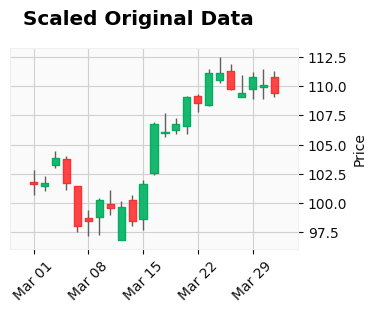

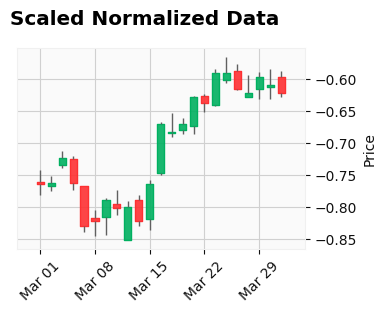

In [10]:
# view both datasets as candle-stick charts, lets say one month each
import matplotlib.pyplot as plt
import mplfinance as mpf

FIG_SCALE = 0.5

plot_data_org = data.loc['2000-03-01':'2000-03-31']
plot_data_nor = scaled_train_df.loc['2000-03-01':'2000-03-31']

mpf.plot(plot_data_org, type='candle', volume=False, title='Scaled Original Data', style='yahoo', figscale=FIG_SCALE)
mpf.plot(plot_data_nor, type='candle', volume=False, title='Scaled Normalized Data', style='yahoo', figscale=FIG_SCALE)

PPO training and evaluation code

In [11]:
from stable_baselines3 import PPO

# Create environment
env = TradingEnv(scaled_train_df, window_size=50)

# Train PPO agent
model = PPO("MlpPolicy", env, verbose=1)    # create PPO (Proximal Policy Optimization) model with MLP policy
model.learn(total_timesteps=100_000)        # train the model for 100,000 timesteps

model.save("../models/ppo_trading")         # save the trained model (the model is now trained until the NOW)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1225 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1166        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009461014 |
|    clip_fraction        | 0.0686      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -2.5        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00128     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00795    |
|    value_loss         

Let's have a training fct

In [ ]:
BET            = 1000.0  # amount to invest per trade
todays_date    = test_data.index[0]
todays_predict = "HOLD"
bank_account   = 0.0
log_df = pd.DataFrame(columns=[
    "date",
    "predicted_action",
    "real_outcome",
    "stock_profit_loss",
    "bank_account"
])

Empty DataFrame
Columns: [date, predicted_action, real_outcome, stock_profit_loss, bank_account]
Index: []
Empty DataFrame
Columns: [date, predicted_action, real_outcome, stock_profit_loss, bank_account]
Index: []


In [ ]:
def get_todays_outcome(date_str):
    if date_str in test_data.index:
        return test_data.loc[date_str]
    else:
        return f"Datum {date_str} nicht gefunden."


In [ ]:
# Let's do one day. Lets get the values we found for todays date
todays_outcome = get_todays_outcome(todays_date)

todays_reward, tomorrows_predict = do_one_step_and_make_prediction(todays_predict, todays_outcome)

bank_account += todays_reward * BET

# log it all
log_df = log_df.append({
    "date": todays_date,
    "predicted_action": todays_predict,
    "real_outcome": todays_outcome['Close'],  # TODO: if psoitive UP - if negative LOW
    "stock_profit_loss": todays_reward * BET,
    "bank_account": bank_account
}, ignore_index=True)

todays_predict = tomorrows_predict


Now let's test the mode


# Test-Umgebung erstellen
test_env = TradingEnv(scaled_test_df, window_size=50)

# Evaluation
obs, info = test_env.reset()                    # reset the environment to start a new episode
total_reward = 0                                # initialize total reward
steps = 0                                       # initialize step counter

while True:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = test_env.step(action)
    total_reward += reward
    steps += 1
    if done:
        break

print(f"Total Reward on Test Data: {total_reward:.4f}")
print(f"Steps: {steps}")
